# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import scipy
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


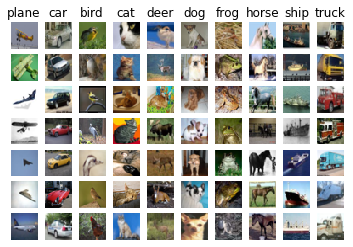

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


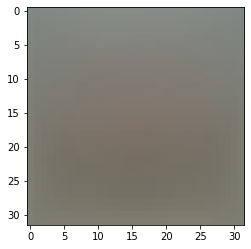

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [11]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss))

loss: 8.734742


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [17]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
print('Checking with zero regularization')
grad_numerical = grad_check_sparse(f, W, grad)

print('Checking with a regularization parameter')
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

Checking with zero regularization
numerical: 7.548676 analytic: 7.548676, relative error: 8.857192e-11
numerical: -10.758009 analytic: -10.758009, relative error: 3.815845e-11
numerical: -41.463152 analytic: -41.463152, relative error: 1.766574e-11
numerical: 22.454904 analytic: 22.454904, relative error: 2.887354e-12
numerical: -5.998027 analytic: -5.998027, relative error: 9.388720e-11
numerical: 9.565331 analytic: 9.565331, relative error: 9.171552e-12
numerical: 1.347601 analytic: 1.347601, relative error: 2.341181e-10
numerical: 10.375454 analytic: 10.375454, relative error: 1.751745e-11
numerical: 3.244750 analytic: 3.244750, relative error: 2.918931e-11
numerical: -11.593329 analytic: -11.593329, relative error: 2.149947e-11
Checking with a regularization parameter
numerical: -8.474924 analytic: -8.474924, relative error: 2.392528e-11
numerical: 32.730281 analytic: 32.730281, relative error: 2.313673e-11
numerical: -7.423515 analytic: -7.423515, relative error: 4.958642e-13
nume

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *Yes it is possible. This discrepancy is caused by that the SVM cost fuction is not diffrentiable at the discontinuty of the cost fuction. There is no reason of concern because we are using the analytical gradient and it is only discontinous at small part of the space (point in 1-d space, line in 2d-space). It should fail near the discontinous point. If we increased the margin, W will scale up, and its derivative will scale which may cause various updates to jump more rapidely across the dicontinous region.*  


In [21]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.734742e+00 computed in 0.126761s
Vectorized loss: 8.734742e+00 computed in 0.002245s
difference: 0.000000


In [22]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.118440s
Vectorized loss and gradient: computed in 0.003835s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [23]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 779.454813
iteration 100 / 1500: loss 282.975312
iteration 200 / 1500: loss 105.881186
iteration 300 / 1500: loss 41.607651
iteration 400 / 1500: loss 18.847653
iteration 500 / 1500: loss 10.496901
iteration 600 / 1500: loss 7.567375
iteration 700 / 1500: loss 6.342361
iteration 800 / 1500: loss 6.006658
iteration 900 / 1500: loss 5.646176
iteration 1000 / 1500: loss 5.498261
iteration 1100 / 1500: loss 4.699683
iteration 1200 / 1500: loss 5.180961
iteration 1300 / 1500: loss 4.887491
iteration 1400 / 1500: loss 5.198460
That took 3.978466s


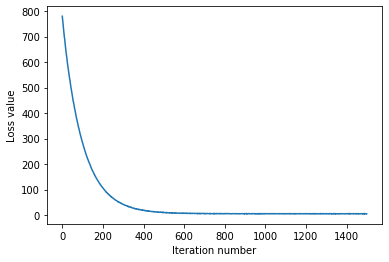

In [24]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [25]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.372327
validation accuracy: 0.380000


In [30]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
import numpy as np
number_of_steps_in_dim = 10
learning_rate_values = np.geomspace(learning_rates[0], learning_rates[1], num=number_of_steps_in_dim)
regularization_strength_values = np.linspace(regularization_strengths[0], regularization_strengths[1], num=number_of_steps_in_dim)
for lr_i in learning_rate_values:
    for lambda_i in regularization_strength_values:
        print('Training SVM with lr={}, lamda={}'.format(lr_i, lambda_i))
        classifier_ij = LinearSVM()
        classifier_ij.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
        y_train_pred = classifier_ij.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = classifier_ij.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr_i, lambda_i)] = (train_accuracy, val_accuracy)
        print('---------------------------------------------')
        print('training accuracy: %f, val accuracy: %f' % (train_accuracy, val_accuracy))
        if best_val < val_accuracy:
            best_val = val_accuracy
            best_svm = classifier_ij
            print('found better model with val accuracy: {}'.format(val_accuracy))
        print('-------------------------------------------------------------------------------------')
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training SVM with lr=1e-07, lamda=25000.0
iteration 0 / 1500: loss 785.516910
iteration 100 / 1500: loss 285.419293
iteration 200 / 1500: loss 107.349036
iteration 300 / 1500: loss 42.482525
iteration 400 / 1500: loss 18.997521
iteration 500 / 1500: loss 10.432294
iteration 600 / 1500: loss 6.975559
iteration 700 / 1500: loss 5.681764
iteration 800 / 1500: loss 5.418025
iteration 900 / 1500: loss 5.609202
iteration 1000 / 1500: loss 5.385980
iteration 1100 / 1500: loss 5.621248
iteration 1200 / 1500: loss 5.233026
iteration 1300 / 1500: loss 5.710148
iteration 1400 / 1500: loss 5.426875
---------------------------------------------
training accuracy: 0.371653, val accuracy: 0.382000
found better model with val accuracy: 0.382
-------------------------------------------------------------------------------------
Training SVM with lr=1e-07, lamda=27777.777777777777
iteration 0 / 1500: loss 776.153297
iteration 100 / 1500: loss 286.191330
iteration 200 / 1500: loss 106.880354
iteration 300

iteration 500 / 1500: loss 10.398480
iteration 600 / 1500: loss 7.159736
iteration 700 / 1500: loss 5.843631
iteration 800 / 1500: loss 5.479143
iteration 900 / 1500: loss 5.291068
iteration 1000 / 1500: loss 5.955429
iteration 1100 / 1500: loss 5.100489
iteration 1200 / 1500: loss 5.161981
iteration 1300 / 1500: loss 5.318619
iteration 1400 / 1500: loss 5.422826
---------------------------------------------
training accuracy: 0.368020, val accuracy: 0.378000
-------------------------------------------------------------------------------------
Training SVM with lr=1.994736598775026e-07, lamda=27777.777777777777
iteration 0 / 1500: loss 786.713104
iteration 100 / 1500: loss 285.986390
iteration 200 / 1500: loss 107.629841
iteration 300 / 1500: loss 42.517129
iteration 400 / 1500: loss 19.111186
iteration 500 / 1500: loss 10.374396
iteration 600 / 1500: loss 7.096323
iteration 700 / 1500: loss 5.212102
iteration 800 / 1500: loss 5.382318
iteration 900 / 1500: loss 5.546266
iteration 1000

iteration 1000 / 1500: loss 4.819909
iteration 1100 / 1500: loss 5.901773
iteration 1200 / 1500: loss 5.968255
iteration 1300 / 1500: loss 5.406939
iteration 1400 / 1500: loss 5.715082
---------------------------------------------
training accuracy: 0.369245, val accuracy: 0.370000
-------------------------------------------------------------------------------------
Training SVM with lr=3.9789740984925684e-07, lamda=27777.777777777777
iteration 0 / 1500: loss 799.882389
iteration 100 / 1500: loss 288.085794
iteration 200 / 1500: loss 108.030921
iteration 300 / 1500: loss 41.853216
iteration 400 / 1500: loss 19.128571
iteration 500 / 1500: loss 10.337947
iteration 600 / 1500: loss 7.259564
iteration 700 / 1500: loss 5.143901
iteration 800 / 1500: loss 5.521925
iteration 900 / 1500: loss 5.577193
iteration 1000 / 1500: loss 5.870607
iteration 1100 / 1500: loss 5.362406
iteration 1200 / 1500: loss 5.855018
iteration 1300 / 1500: loss 5.336777
iteration 1400 / 1500: loss 5.129621
---------

---------------------------------------------
training accuracy: 0.369000, val accuracy: 0.380000
-------------------------------------------------------------------------------------
Training SVM with lr=7.937005259840992e-07, lamda=27777.777777777777
iteration 0 / 1500: loss 789.346971
iteration 100 / 1500: loss 287.692562
iteration 200 / 1500: loss 108.920050
iteration 300 / 1500: loss 42.711491
iteration 400 / 1500: loss 19.264548
iteration 500 / 1500: loss 10.353057
iteration 600 / 1500: loss 6.862481
iteration 700 / 1500: loss 6.358391
iteration 800 / 1500: loss 5.861739
iteration 900 / 1500: loss 5.604990
iteration 1000 / 1500: loss 5.977772
iteration 1100 / 1500: loss 5.417878
iteration 1200 / 1500: loss 5.586384
iteration 1300 / 1500: loss 5.059707
iteration 1400 / 1500: loss 5.650094
---------------------------------------------
training accuracy: 0.371000, val accuracy: 0.384000
-------------------------------------------------------------------------------------
Training SV

iteration 100 / 1500: loss 285.760467
iteration 200 / 1500: loss 107.797359
iteration 300 / 1500: loss 42.157491
iteration 400 / 1500: loss 18.936405
iteration 500 / 1500: loss 10.199288
iteration 600 / 1500: loss 7.144479
iteration 700 / 1500: loss 5.900980
iteration 800 / 1500: loss 5.402107
iteration 900 / 1500: loss 5.126706
iteration 1000 / 1500: loss 5.261340
iteration 1100 / 1500: loss 5.750176
iteration 1200 / 1500: loss 5.350237
iteration 1300 / 1500: loss 4.957406
iteration 1400 / 1500: loss 5.514243
---------------------------------------------
training accuracy: 0.364796, val accuracy: 0.384000
-------------------------------------------------------------------------------------
Training SVM with lr=1.5832234876474744e-06, lamda=30555.555555555555
iteration 0 / 1500: loss 785.854390
iteration 100 / 1500: loss 287.225202
iteration 200 / 1500: loss 108.158808
iteration 300 / 1500: loss 42.829591
iteration 400 / 1500: loss 18.682850
iteration 500 / 1500: loss 9.929886
iteratio

iteration 600 / 1500: loss 7.351516
iteration 700 / 1500: loss 6.042350
iteration 800 / 1500: loss 5.889248
iteration 900 / 1500: loss 4.975643
iteration 1000 / 1500: loss 5.525356
iteration 1100 / 1500: loss 5.380762
iteration 1200 / 1500: loss 4.998458
iteration 1300 / 1500: loss 4.972524
iteration 1400 / 1500: loss 5.243104
---------------------------------------------
training accuracy: 0.369184, val accuracy: 0.383000
-------------------------------------------------------------------------------------
Training SVM with lr=3.158113834850658e-06, lamda=30555.555555555555
iteration 0 / 1500: loss 794.787400
iteration 100 / 1500: loss 290.461487
iteration 200 / 1500: loss 108.364831
iteration 300 / 1500: loss 43.220190
iteration 400 / 1500: loss 19.102711
iteration 500 / 1500: loss 10.285883
iteration 600 / 1500: loss 7.060412
iteration 700 / 1500: loss 5.705599
iteration 800 / 1500: loss 5.879348
iteration 900 / 1500: loss 5.687037
iteration 1000 / 1500: loss 5.241108
iteration 1100

iteration 1100 / 1500: loss 5.023634
iteration 1200 / 1500: loss 5.626505
iteration 1300 / 1500: loss 4.984651
iteration 1400 / 1500: loss 5.698092
---------------------------------------------
training accuracy: 0.368163, val accuracy: 0.368000
-------------------------------------------------------------------------------------
Training SVM with lr=6.299605249474357e-06, lamda=30555.555555555555
iteration 0 / 1500: loss 785.942886
iteration 100 / 1500: loss 288.271361
iteration 200 / 1500: loss 108.858693
iteration 300 / 1500: loss 42.835029
iteration 400 / 1500: loss 19.094391
iteration 500 / 1500: loss 10.653048
iteration 600 / 1500: loss 6.884493
iteration 700 / 1500: loss 6.416848
iteration 800 / 1500: loss 5.498504
iteration 900 / 1500: loss 5.010777
iteration 1000 / 1500: loss 4.694847
iteration 1100 / 1500: loss 5.407390
iteration 1200 / 1500: loss 5.627799
iteration 1300 / 1500: loss 5.118238
iteration 1400 / 1500: loss 5.218899
---------------------------------------------
t

iteration 100 / 1500: loss 286.097321
iteration 200 / 1500: loss 107.580009
iteration 300 / 1500: loss 42.386087
iteration 400 / 1500: loss 18.990423
iteration 500 / 1500: loss 10.680779
iteration 600 / 1500: loss 6.773913
iteration 700 / 1500: loss 6.733954
iteration 800 / 1500: loss 5.405075
iteration 900 / 1500: loss 4.773074
iteration 1000 / 1500: loss 5.791980
iteration 1100 / 1500: loss 5.327520
iteration 1200 / 1500: loss 5.195842
iteration 1300 / 1500: loss 5.532239
iteration 1400 / 1500: loss 5.672717
---------------------------------------------
training accuracy: 0.371388, val accuracy: 0.382000
-------------------------------------------------------------------------------------
Training SVM with lr=1.2566053148961804e-05, lamda=33333.333333333336
iteration 0 / 1500: loss 792.116420
iteration 100 / 1500: loss 287.182068
iteration 200 / 1500: loss 108.494824
iteration 300 / 1500: loss 42.650341
iteration 400 / 1500: loss 19.536432
iteration 500 / 1500: loss 9.904056
iteratio

iteration 500 / 1500: loss 10.135764
iteration 600 / 1500: loss 7.560223
iteration 700 / 1500: loss 5.727375
iteration 800 / 1500: loss 6.025533
iteration 900 / 1500: loss 4.929186
iteration 1000 / 1500: loss 5.528085
iteration 1100 / 1500: loss 5.748760
iteration 1200 / 1500: loss 5.392627
iteration 1300 / 1500: loss 5.497123
iteration 1400 / 1500: loss 4.867343
---------------------------------------------
training accuracy: 0.366041, val accuracy: 0.376000
-------------------------------------------------------------------------------------
Training SVM with lr=2.506596611838633e-05, lamda=33333.333333333336
iteration 0 / 1500: loss 779.723129
iteration 100 / 1500: loss 284.008555
iteration 200 / 1500: loss 107.123476
iteration 300 / 1500: loss 42.758051
iteration 400 / 1500: loss 18.643776
iteration 500 / 1500: loss 10.535687
iteration 600 / 1500: loss 7.094826
iteration 700 / 1500: loss 5.759652
iteration 800 / 1500: loss 5.762656
iteration 900 / 1500: loss 4.984368
iteration 1000

iteration 1000 / 1500: loss 4.924485
iteration 1100 / 1500: loss 5.526612
iteration 1200 / 1500: loss 5.216394
iteration 1300 / 1500: loss 5.760909
iteration 1400 / 1500: loss 4.936307
---------------------------------------------
training accuracy: 0.366633, val accuracy: 0.373000
-------------------------------------------------------------------------------------
Training SVM with lr=4.9999999999999996e-05, lamda=33333.333333333336
iteration 0 / 1500: loss 788.020733
iteration 100 / 1500: loss 288.132453
iteration 200 / 1500: loss 108.050210
iteration 300 / 1500: loss 42.934220
iteration 400 / 1500: loss 18.624534
iteration 500 / 1500: loss 10.078292
iteration 600 / 1500: loss 7.184187
iteration 700 / 1500: loss 5.933789
iteration 800 / 1500: loss 5.018044
iteration 900 / 1500: loss 5.292069
iteration 1000 / 1500: loss 5.500369
iteration 1100 / 1500: loss 5.708068
iteration 1200 / 1500: loss 4.905780
iteration 1300 / 1500: loss 5.879748
iteration 1400 / 1500: loss 5.440646
---------

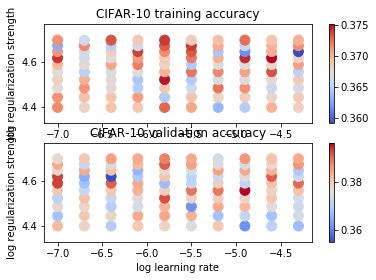

In [31]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [32]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.368000


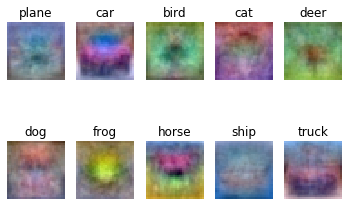

In [33]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *They look like global templates for matching each category (plane is like the superpositions of many plane images, horse looks like it had 2 necks), and they are looking like that because we are using simple linear classifier for obtaining class scores*  
